In [102]:
import imutils
import numpy as np
import cv2
import matplotlib.pyplot as plt
import argparse
import tensorflow as tf
from imutils.object_detection import non_max_suppression
import time
from tensorflow import keras
import os

In [103]:
#collapse-hide
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", default = './Datasets/test2.jpg', #required=False,
    help="path to the input image")
ap.add_argument("-s", "--size", type=str, default="(100, 100)",
    help="ROI size (in pixels)")
ap.add_argument("-c", "--min-conf", type=float, default=0.9,
    help="minimum probability to filter weak detections")
ap.add_argument("-v", "--visualize", type=int, default=1,
    help="whether or not to show extra visualizations for debugging")
args = vars(ap.parse_args([]))

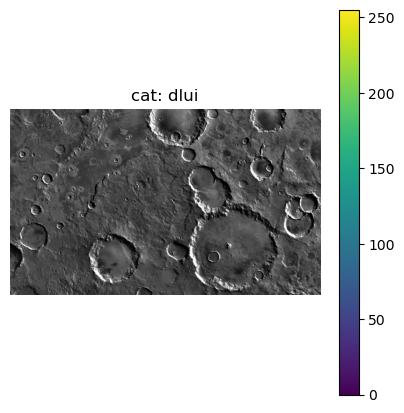

In [104]:
#collapse-hide
image = cv2.imread(args["image"])
#print(image.shape)
# resize image keeping aspect ratio
#r = 224 / image.shape[1] # ratio of new width /old width
#dim = (224, int(image.shape[0] * r)) # resized height
#image = cv2.resize(image, dim)
# move to RGB map
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# display image
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_title("cat: dlui")
plt.imshow(image)
plt.axis("off")
plt.colorbar()

In [105]:
def sliding_window(image, step, ws):
    #slide a window of ws size over the image
    for y in range(0, image.shape[0]-ws[1], step): # rows-wise loop
        # -ws[1] avoids extending the sliding window outside the image itself, increment the y-position with step
        for x in range(0, image.shape[1] - ws[0], step):#columns-wise loop, increment the x-position with step
            # use yield(instead of return) because this is a generator
            #yield the actual x and y positions and the current window
            yield (x, y, image[y:y + ws[1], x:x + ws[0]]) 

In [106]:
def image_pyramid(image, scale=1.5, minSize=(100, 100)):
    # yield the original image, this is the base of the image pyramid
    yield image
    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        #scale controls how much the image is resized at each layer
        w = int(image.shape[1] / scale)
        # resize the image and take care of image aspect-ratio
        image = imutils.resize(image, width=w) 
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image

In [107]:
# initialize variables used for the object detection procedure
WIDTH = 600 # 
PYR_SCALE = 1.5
WIN_STEP = 150 # running on laptop so I generated a small pyramid
ROI_SIZE = eval(args["size"])
INPUT_SIZE = (227, 227) # input of resnet model.summary()


ROI_SIZE

(100, 100)

In [108]:
# resize  image- note that it doesn not fit the input to ResNet50
orig = image
orig = imutils.resize(orig, width = WIDTH)
(H, W) = orig.shape[:2] 

In [109]:
(H,W)

(360, 600)

In [ ]:
# initialize the image pyramid
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)
# initialize two lists, one to hold the ROIs generated from the image pyramid 
#and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []
# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()
counter = 0
tot_images = 0
for p, image in enumerate(pyramid):
    # determine the scale factor between the *original* image
    # dimensions and the *current* layer of the pyramid
    scale = W / float(image.shape[1])
    # for each layer of the image pyramid, loop over the sliding
    # window locations
    sw = 0
    for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        sw = sw + 1
        # scale the (x, y)-coordinates of the ROI with respect to the
        # *original* image dimensions
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[1] * scale)
        # take the ROI and pre-process it so we can later classify
        # the region using Keras/TensorFlow
        roi = cv2.resize(roiOrig, INPUT_SIZE)
        roi = tf.keras.preprocessing.image.img_to_array(roi)
        roi = tf.keras.applications.resnet.preprocess_input(roi)
        #print(roiOrig.shape, roi.shape)
        # update our list of ROIs and associated coordinates
        rois.append(roi)
        locs.append((x, y, x + w, y + h))
        # check to see if we are visualizing each of the sliding
        # windows in the image pyramid
        if args["visualize"] > 0:
            # clone the original image and then draw a bounding box
            # surrounding the current region
            clone = orig.copy()
            cv2.rectangle(clone, (x, y), (x + w, y + h),(0, 255, 0), 5)
            # show the visualization and current ROI
            plt.imshow(clone)
            var_name = "p" + str(p)+"_" + "sw" + str(sw) + ".jpg"
            plt.savefig("images/clone_"+ var_name)
            plt.imshow(roiOrig)
            plt.savefig("images/roiOrig_"+ var_name)
            cv2.waitKey(0)
            tot_images = tot_images +1
        
        
        
        print(roiOrig.shape, roi.shape)
# show how long it took to loop over the image pyramid layers and
# sliding window locations
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(end - start))
print("Total images {:.2f}".format(tot_images))

In [111]:
model = keras.models.load_model(r'./models/cnn2.h5')

In [112]:
CATEGORIES = ['bright_dune', 'crater','dark_dune','impact_ejecta','slope_streak']

In [113]:
def findClass(image_path):
    image_1 = cv2.imread(image_path)
    image_1 = cv2.resize(image_1, (227, 227))
    np.array(image_1).reshape(-1, 227, 227, 3)
    image_1 = image_1.astype('float32')
    image_1 /= 255 
    prediction = model.predict(np.array([image_1], np.float32))
    # print(prediction)
    return CATEGORIES[np.argmax(prediction)]

In [114]:
# convert the ROIs to a NumPy array
rois = np.array(rois, dtype="float32")
# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
my_preds = model.predict(rois)
end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(end - start))

[INFO] classifying ROIs...
[INFO] classifying ROIs took 0.28458 seconds


In [115]:
print(CATEGORIES[np.argmax(my_preds[0])])

slope_streak


In [ ]:
print(my_preds)